Рассмотрим задачу о намерзании льда на поверхности водоёма глубиной $1$ метр, который в начальный момент времени находится полностью в жидком состоянии.

Для этого решим уравнение теплопроводности, при учёте фазового перехода в среде, считая, что плотность среды $\rho$ не изменяется при фазовом перходе.

$$\begin{cases}
    \rho c_s \frac{\partial T}{\partial t} = a_s \frac{\partial^2 T}{\partial x^2}, \; 0 < x < y(t) \\
    \rho c_f \frac{\partial T}{\partial t} = a_f \frac{\partial^2 T}{\partial x^2}, \; y(t) < x < 1 \\
    T(y(t), t) = T_p
\end{cases}$$

Здесь $y(t)$ - граница раздела фаз, $T(x, t)$ - распределние температуры, $T_p = 273 \text{К}$ - температура плавления льда.

Также необходимо учесть условие баланса энергии при движении фазового фронта:

$$a_s \frac{\partial T}{\partial x}(y(t) - 0, t) - a_f \frac{\partial T}{\partial x}(y(t) + 0, t) = \rho L \frac{\mathrm{d} y}{\mathrm{d} t}$$

Это уравнение будем использовать для определения положения границы раздела вместо $T(y(t), t) = T_p$.

В качестве начально-краевых условий возмём:

$T(x, 0) = \varphi(x) = \left( 7x + 273 \right) \text{К}$

$T(0, t) = \Psi_l(t) = [273 - 13(1 - e^{-10t})] \text{К}$ - поверхность водоёма

$T(1, t) = \Psi_r(t) =  280 \text{К}$ - дно водоёма

Значения физических постоянных:

$\rho=1000 \frac{\text{кг}}{\text{м}^3}$

$T_p=273 \text{K}$

$L=3.3 \cdot 10^5 \frac{\text{Дж}}{\text{кг}}$

$c_f=4200 \frac{\text{Дж}}{\text{кг}\cdot\text{K}}$

$a_f=0.56 \frac{\text{Вт}}{\text{м}\cdot\text{K}}$

$c_s=2100 \frac{\text{Дж}}{\text{кг}\cdot\text{K}}$

$a_s=2.25 \frac{\text{Вт}}{\text{м}\cdot\text{K}}$

Условие устойчиовсти явной схемы:

$\max\{\frac{a_s\tau}{\rho c_s h^2}, \frac{a_f\tau}{\rho c_f h^2}\} < \frac{1}{2}$

$\tau < 4.67 \cdot 10^5 \cdot h^2$

Для интервала времени $T = 10^5 \text{с}$:

$\frac{1}{N} < \frac{4.67}{M^2} \Rightarrow M < \sqrt{4.67 \cdot N}$

$N = 10^4 \Rightarrow M = 216$

In [19]:
import matplotlib.pyplot as plt
from PDElib import * # HESolver(methods for solving heat equations), HEParams, Grid
from math import *

phi = lambda x: 7*x + 273
psi_l = lambda t: 273 - 13*(1 - exp(-10*t))
psi_r = lambda t: 280

grid = Grid(1e5, 10000, 1, 216)
params = HEParams(rho=1000, T_p=273, L=3.3e5, c_f=4200, a_f=0.56, c_s=2100, a_s=2.25)

def find_phase_front(T: list[float], h: float, T_p: float) -> float:
    for m in range(len(T) - 1):
        if (T[m] - T_p) * (T[m+1] - T_p) <= 0:
            theta = (T_p - T[m]) / (T[m+1] - T[m])
            return h * (m + theta)
    return 0.0 if T[0] >= T_p else len(T)*h

def plot_temperature_and_phase_front(y : list[float], T : list[list[float]], grid : Grid):
    h = grid.L / grid.M
    tau = grid.T / grid.N
    x = [h*m for m in range(grid.M + 1)]
    t = [tau*n for n in range(grid.N + 1)]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    T_transposed = list(map(list, zip(*T)))
    plt.pcolormesh(t, x, T_transposed, cmap="Blues")
    plt.gca().invert_yaxis()
    plt.colorbar(label='Temperature (K)').ax.invert_yaxis()
    plt.xlabel("t, s")
    plt.ylabel("x(depth), m")
    plt.title("temperature distribution")
    plt.subplot(1, 2, 2)
    plt.plot(t, y, label="energy balance")
    plt.plot(t, [find_phase_front(T[n], h, 273) for n in range(grid.N + 1)], "--", label="temperature")
    plt.xlabel("t, s")
    plt.ylabel("phase front position y(t), m")
    plt.title("phase front movement")
    plt.tight_layout()
    plt.legend()
    plt.show()

def plot_temperature_profile_at_time(T : list[list[float]], grid : Grid, t : float):
    if not (0 <= t <= grid.T):
        raise ValueError(f"Argument t should be between 0 and {grid.T}")
    h = grid.L / grid.M
    tau = grid.T / grid.N
    n = int(t / tau)
    x = [h*m for m in range(grid.M + 1)]
    T_profile = T[n]
    plt.plot(x, T_profile, label=f"T(x), t = {t:.0f} s")
    plt.xlabel("x(depth), m")
    plt.ylabel("T, K")
    plt.title("temperature profiles")
    plt.tight_layout()
    plt.legend()

### Явная 4-х точечная схема

![stencil](stencils/explicit_4point.png)

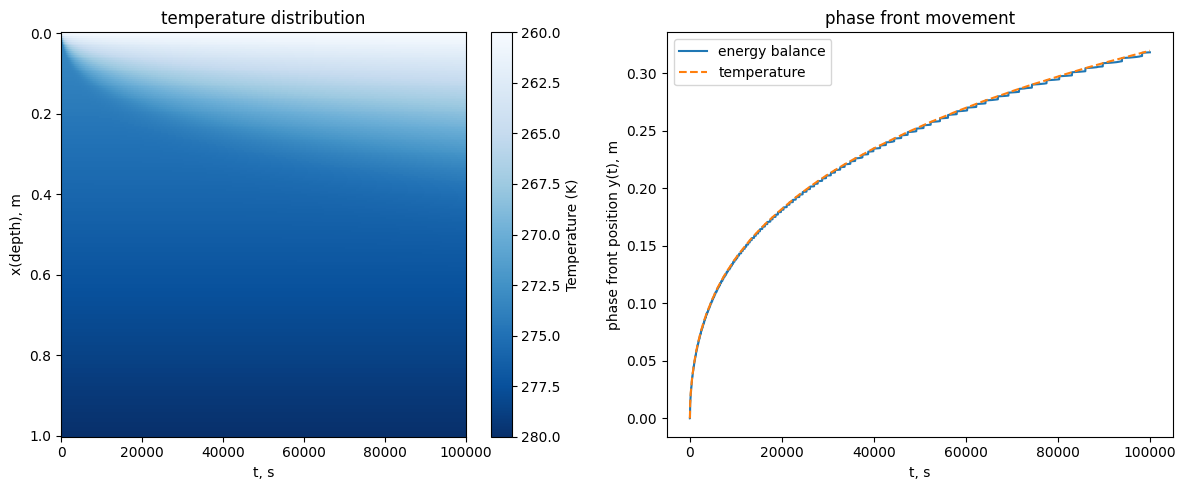

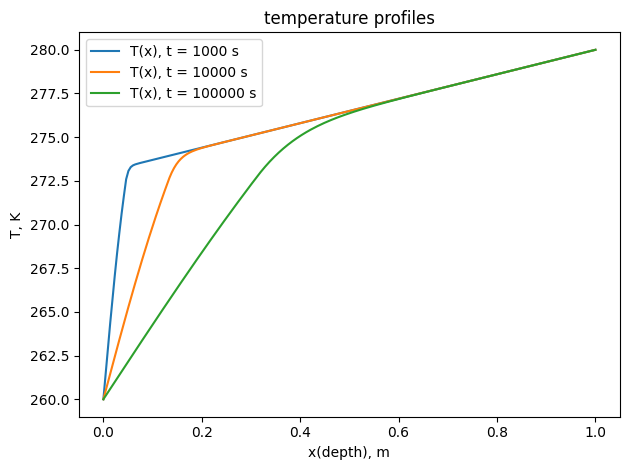

In [20]:
y, T = HESolver.solve_by_explicit_4point_scheme(params, grid, phi, psi_l, psi_r)
plot_temperature_and_phase_front(y, T, grid)

plot_temperature_profile_at_time(T, grid, 1e3)
plot_temperature_profile_at_time(T, grid, 1e4)
plot_temperature_profile_at_time(T, grid, 1e5)

### Неявная 4-х точеная схема

![stencil](stencils/implicit_4point.png)

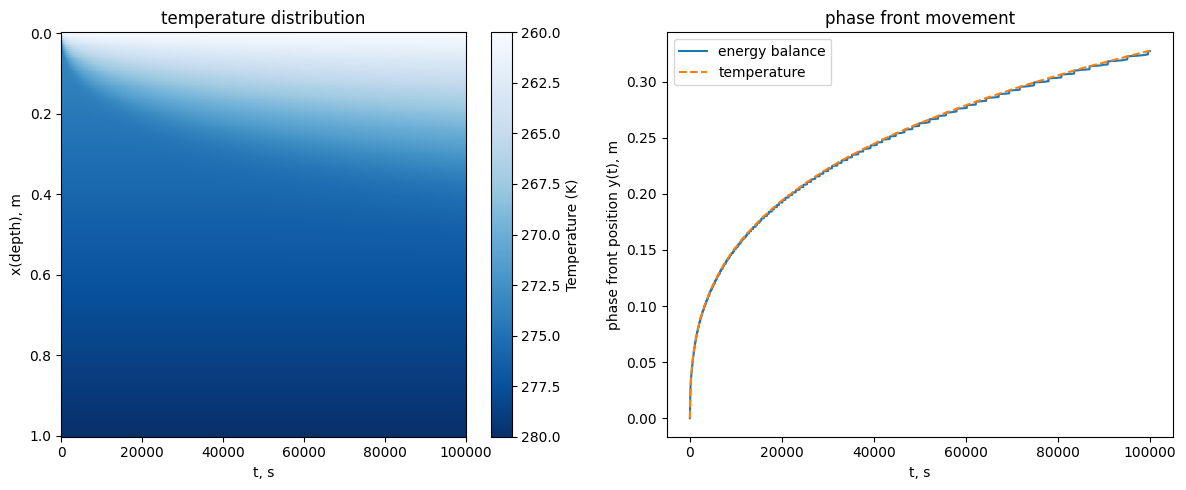

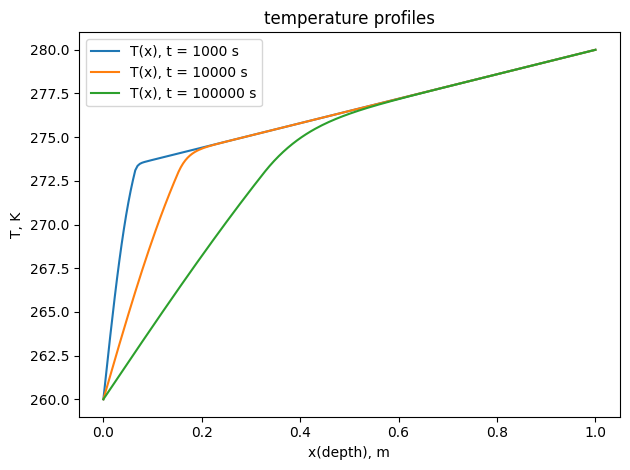

In [21]:
y, T = HESolver.solve_by_implicit_4point_scheme(params, grid, phi, psi_l, psi_r)
plot_temperature_and_phase_front(y, T, grid)

plot_temperature_profile_at_time(T, grid, 1e3)
plot_temperature_profile_at_time(T, grid, 1e4)
plot_temperature_profile_at_time(T, grid, 1e5)

### Схема Кранка-Николсона

![stencil](stencils/Crank-Nicolson_method.png)

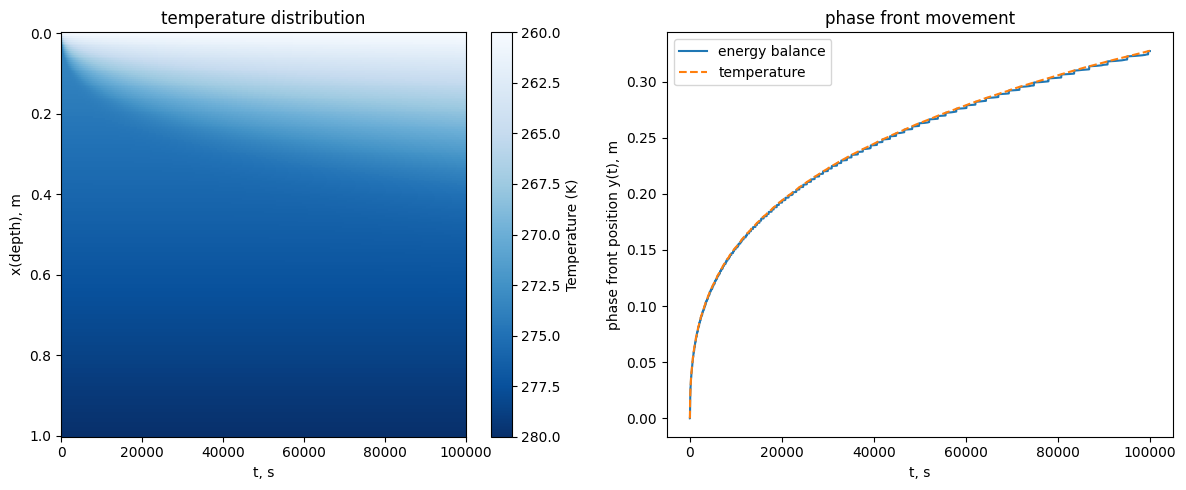

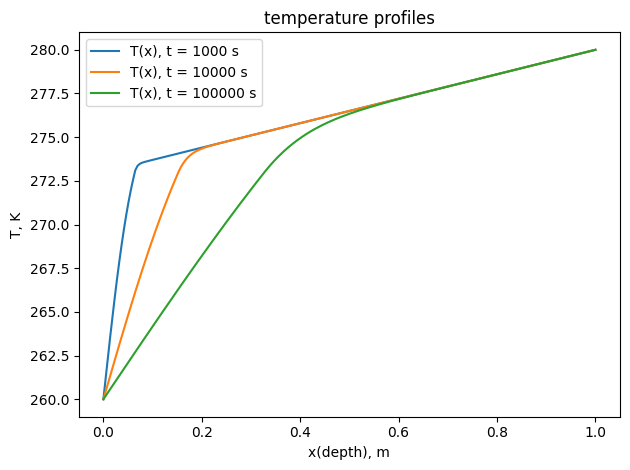

In [22]:
y, T = HESolver.solve_by_Crank_Nicolson_scheme(params, grid, phi, psi_l, psi_r)
plot_temperature_and_phase_front(y, T, grid)

plot_temperature_profile_at_time(T, grid, 1e3)
plot_temperature_profile_at_time(T, grid, 1e4)
plot_temperature_profile_at_time(T, grid, 1e5)

## Оценка погрешности

При оценки погрешности зафиксируем  $T = 3600 \text{с}, \; N = 10^4$

Построим графики зависимости ошибки от шага по пространству в двойном логарифмическом масштабе и оценим порядки схем по углам наклона.

explicit 4-point spatial order =  1.1742890602088731
implicit 4-point spatial order =  1.4160927419849088
Crank-Nicolson spatial order =  1.4141914848281452


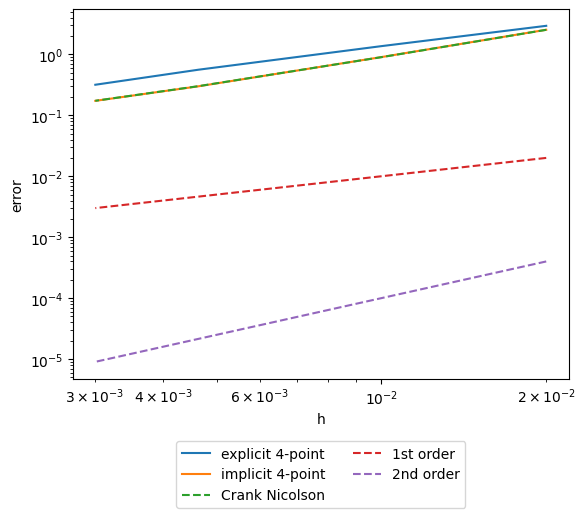

In [29]:
explicit4_errs = []
implicit4_errs = []
CN_errs = []
hs = []

Ms = [50, 100, 216, 333]
M_reference = 1500
T = 3600
grid = Grid(T, 10000, 1, M_reference)
u_reference = HESolver.solve_by_Crank_Nicolson_scheme(params, grid, phi, psi_l, psi_r)[1]

def get_error(u : list[list[float]], grid : Grid):
    err2 = 0
    h = grid.L / grid.M
    tau = grid.T / grid.N
    for m in range(M_reference + 1):
        err2 += abs(u[grid.N][int(m * grid.M / M_reference)] - u_reference[grid.N][m])**2
    return sqrt(err2 / grid.M)

for M in Ms:
    grid = Grid(T, 10000, 1, M)
    explicit4_errs += [get_error(HESolver.solve_by_explicit_4point_scheme(params, grid, phi, psi_l, psi_r)[1], grid)]
    implicit4_errs += [get_error(HESolver.solve_by_implicit_4point_scheme(params, grid, phi, psi_l, psi_r)[1], grid)]
    CN_errs += [get_error(HESolver.solve_by_Crank_Nicolson_scheme(params, grid, phi, psi_l, psi_r)[1], grid)]
    hs += [grid.L / grid.M]

plt.plot(hs, explicit4_errs, label="explicit 4-point")
plt.plot(hs, implicit4_errs, label="implicit 4-point")
plt.plot(hs, CN_errs, "--", label="Crank Nicolson")
plt.plot(hs, [x for x in hs], "--", label="1st order")
plt.plot(hs, [x*x for x in hs], "--", label="2nd order")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("h")
plt.ylabel("error")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
print("explicit 4-point spatial order = ", -log(explicit4_errs[-1]/explicit4_errs[0])/log(Ms[-1]/Ms[0]))
print("implicit 4-point spatial order = ", -log(implicit4_errs[-1]/implicit4_errs[0])/log(Ms[-1]/Ms[0]))
print("Crank-Nicolson spatial order = ", -log(CN_errs[-1]/CN_errs[0])/log(Ms[-1]/Ms[0]))